# 1D Monitoring Element Exploration

This notebooks provides some examples on how to access and visualize 1D monitoring elements using `cmsdials` and the visualization tools provided by `dqmexplore`.

## Imports

In [ ]:
# Setting up DIALS object and importing dqmexplore
import sys
sys.path.append("../src/")

from utils.setupdials import setup_dials_object_deviceauth
dials = setup_dials_object_deviceauth()

import dqmexplore as dqme

In [ ]:
# Importing DIALS objects
# For more information on DIALS, please visit https://github.com/cms-DQM/dials-py
from cmsdials.filters import LumisectionHistogram1DFilters, LumisectionHistogram2DFilters

# Importing other essential packages
import numpy as np
import pandas as pd

In [ ]:
# Run this cell to see the list of all available 1D MEs
mes_df = pd.DataFrame([me_qry_rslt.__dict__ for me_qry_rslt in dials.mes.list()])
avail_mes_df = mes_df[mes_df["dim"] == 1]

metype_names = []
for me in avail_mes_df["me"]:
    metype_name = me.split("/")[0]
    if metype_name not in metype_names: metype_names.append(metype_name)
        
print("Available types of MEs:", metype_names)
for me in avail_mes_df[avail_mes_df["me"].str.contains(metype_names[0])]["me"]:
    print(me)
avail_mes_df

## 1D Monitoring Elements

In [ ]:
# Obtaininng ME data from DIALS
runnb = 380238
me__regex =  "PixelPhase1/Tracks/PXBarrel/charge_PXLayer_." 

data1D = dials.h1d.list_all(
    LumisectionHistogram1DFilters(
        run_number = runnb,
        dataset__regex = "ZeroBias",
        me__regex = me__regex
    ),
    # max_pages=200
).to_pandas()

# Checking for any empty LSs in the selected MEs
dqme.exploreutils.check_empty_lss(data1D)

In [ ]:
# Getting trigger rate and plotting it
trig_rate = dqme.omsutils.get_rate(dials, runnb, "ZeroBias")
dqme.omsutils.plot_rate(trigratedata, norm=False, show=True)

In [ ]:
# Getting reference data 
# (Optional. If not desired, don't use the ref_df argument in the plot1DMEs function)
refrun = 379765

refdata1D = dials.h1d.list_all(
    LumisectionHistogram1DFilters(
        run_number = refrun,
        dataset__regex = "ZeroBias",
        me__regex = me__regex
    ),
    # max_pages=200
).to_pandas()

# Checking for any empty LSs in the reference run's MEs
dqme.exploreutils.check_empty_lss(refdata1D)

In [ ]:
# Defining plot features and plotting
ax_labels = [
    dict(
        x="Charge (e)", 
        y="Count"
    )
] * 4

fig_title = f"Pixel Barrel Charge Normalized (Run {runnb})"

# Plotting
fig = dqme.plotting.plot1DMEs(
    data1D, 
    fig_title=fig_title,
    ax_labels=ax_labels, 
    width=1000,
    height=1000,
    vspace=0.1,
    hspace=0.1,
    trigger_rates=trig_rate, 
    norm=True,
    ref_df=refdata1D,
    show=True
)

If you wish to further modify the figure `dqmexplore` gives you, you can do so by setting `show=False`, and using `plotly` to change the elements of the plot.

In [ ]:
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Add modifications to fig here.


And if you wish to export the plot to an HTML file, you can run the code show below after setting `show=False`.

In [ ]:
# You can set show=False and export the figure to an HTML file by also running the code below
from plotly.offline import plot
plot(fig, filename=f"./fig.html")

### Heatmaps

By "stacking" 1D histograms, we can create heatmaps which give us an idea of how the run evolved through time as data was being taken. 

These can also be exported to an HTML file similarly to the example shown previously.

In [ ]:
# Getting current run data
runnb = 380238
me__regex =  "PixelPhase1/Tracks/PXBarrel/charge_PXLayer_." 

data1D = dials.h1d.list_all(
    LumisectionHistogram1DFilters(
        run_number = runnb,
        dataset__regex = "ZeroBias",
        me__regex = me__regex
    ),
    # max_pages=200
).to_pandas()

In [ ]:
# Getting trigger rate
trig_rate = dqme.omsutils.get_rate(dials, runnb, "ZeroBias")

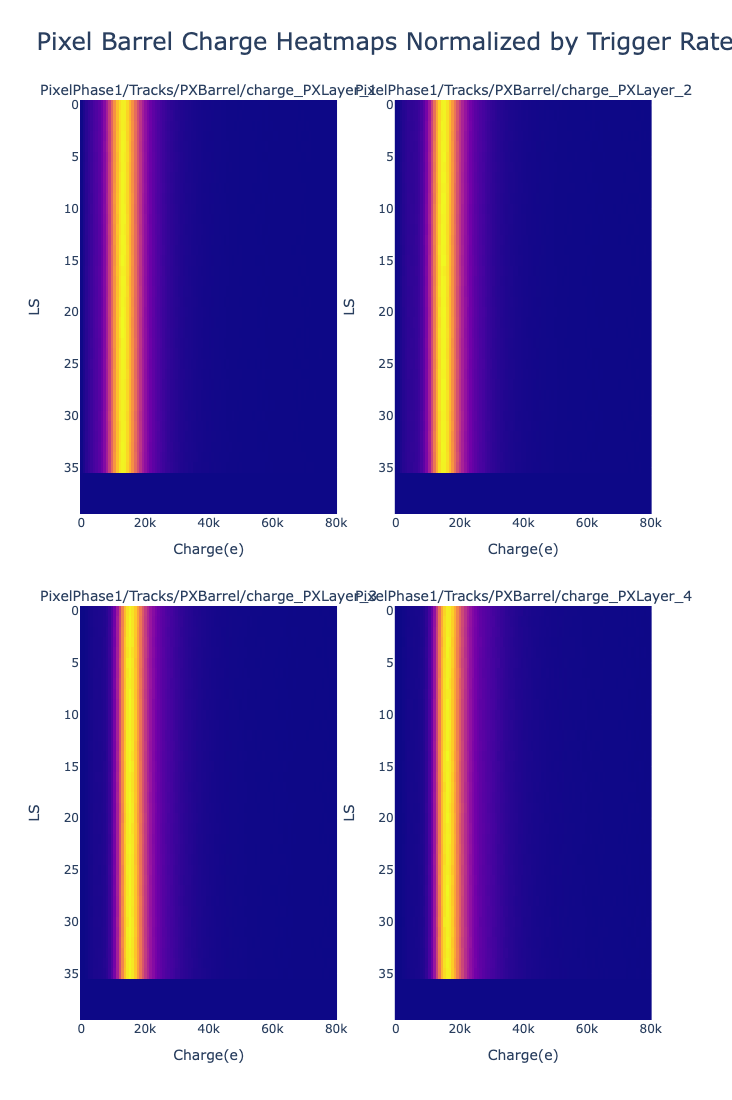

In [58]:
# Defining plot features and plotting
ax_labels = [
    dict(x = "Charge(e)", y = "LS")
] * 4

fig_title = f"Pixel Barrel Charge Heatmaps Normalized by Trigger Rate (Run {runnb})"

fig = dqme.statplotting.plotheatmaps1D(
    data1D,
    fig_title=fig_title,
    ax_labels=ax_labels,
    trigger_rates = trig_rate,
    norm=True,
    show=True,
)